# Bone Mineral Density
Relative spinal bone mineral density measurements on 261 North American adolescents.  The response is relative change in spinal BMD (the difference in spnbmd taken on two consecutive visits, divided by the average), typically about one year apart. The age is the average age over the two visits.

Variables:

|        |                                                       |
|--------|-------------------------------------------------------|
|idnum   |identifies the child, and hence the repeat measurements|
|age     |average age of child when measurements were taken      |
|gender  |male or female                                         |
|spnbmd  |Relative Spinal bone mineral density measurement       |

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
RED, BLUE, GRAY4 = '#FF5865', '#0000FF', '#646369'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Bone Mineral Density.txt", sep='\t')
df_male = df[df.gender == 'male']
df_female = df[df.gender == 'female']
df.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


## Smoothing Splines
Unfortunately, I did not find any Python library for smoothing splines of a similar implementation from the book. Let's implement it ourselves. To automate differentiation and integration, we will use the symbolic computation library sympy. It works extremely slowly for our task. A quick but less clear implementation can be found in this jupyter notebook "5 Basis Expansions and Regularization/4 Smoothing Splines.ipynb".

In [3]:
from sympy import *

In [4]:
# PAGE 145. A natural cubic spline with K knots is represented by K basis
#           functions.
def buid_basis_functions(knots):
    x_min, x_max = min(knots), max(knots)
    x = symbols('x')
    dK_1 = (x-knots[-2])**3/(knots[-1] - knots[-2])
    h = [S.One, x]
    for i in range(knots.shape[0] - 2):
        n = (x - knots[i])**3/(knots[-1] - knots[i])
        h.append(Piecewise(
            (0, x < knots[i]),
            (n-dK_1, x > knots[-2]),
            (n, True)))
    return h


# PAGE 146. Each basis function is evaluated at each of the N samples,
#           resulting in a N × df basis matrix H.
def calc_basis_matrix(basis_functions, x):
    H = np.zeros((x.shape[0], len(basis_functions)))
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            H[i, j] = basis_functions[j].evalf(subs={'x': x[i]})
    return H


# PAGE 152. The solution is easily seen to be (5.12) a generalized ridge
#           regression.
def calc_omega_matrix(basis_functions, knots):
    s = len(basis_functions)
    basis_functions_diffs = [bs.diff('x', 2) for bs in basis_functions]
    O = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            if j > i or i <= 1 or j <= 1:
                continue
            bs_i, bs_j = basis_functions_diffs[i], basis_functions_diffs[j]
            # NOTE: sympy has errors when integrating piecewise functions
            #       please, be carefull
            O[i, j] = integrate(bs_i*bs_j,
                                ('x', max(knots[i-2], knots[j-2]), knots[-1]))
            O[j, i] = O[i, j]
    return O

In [5]:
# given data frame with male/female samples, calculates matrices H, Ω and
# matrices for plotting
def calc_matrices(df):
    x, y = df.age.values, df.spnbmd.values
    knots = np.unique(x)
    x_plot = np.linspace(knots[0], knots[-1], 100)
    h = buid_basis_functions(knots)
    H = calc_basis_matrix(h, x)
    H_plot = calc_basis_matrix(h, x_plot)
    O = calc_omega_matrix(h, knots)
    return H, O, H_plot, x_plot

In [6]:
H_male, O_male, H_plot_male, x_plot_male = calc_matrices(df_male)
H_female, O_female, H_plot_female, x_plot_female = calc_matrices(df_female)

In [7]:
# PAGE 153. By analogy we define the effective degrees of freedom of a
#           smoothing spline to be df_l=trace(S_l)
def calc_degress_of_freedom(H, O, l):
    Sl = H @ np.linalg.inv(H.T @ H + l*O) @ H.T
    return np.trace(Sl)


# PAGE 152. The solution is easily seen to be (5.12) a generalized ridge
#           regression. The fitted smoothing spline is given by (5.13).
def calc_model_parameters(H, O, l, y):
    theta = np.linalg.inv(H.T @ H + l*O) @ H.T @ y
    return theta

In [8]:
# NOTE: In the book, they have 12 degrees of freedom with the lambda equals to
#       0.00022. But that number didn't work for me.
l = 0.00022*3600
print(f'MALE DF={calc_degress_of_freedom(H_male, O_male, l):.2f}')
print(f'FEMALE DF={calc_degress_of_freedom(H_female, O_female, l):.2f}')
theta_male = calc_model_parameters(H_male, O_male, l, df_male.spnbmd.values)
theta_female = calc_model_parameters(
    H_female, O_female, l, df_female.spnbmd.values)

MALE DF=12.17
FEMALE DF=12.81


In [9]:
y_plot_male = H_plot_male @ theta_male
y_plot_female = H_plot_female @ theta_female

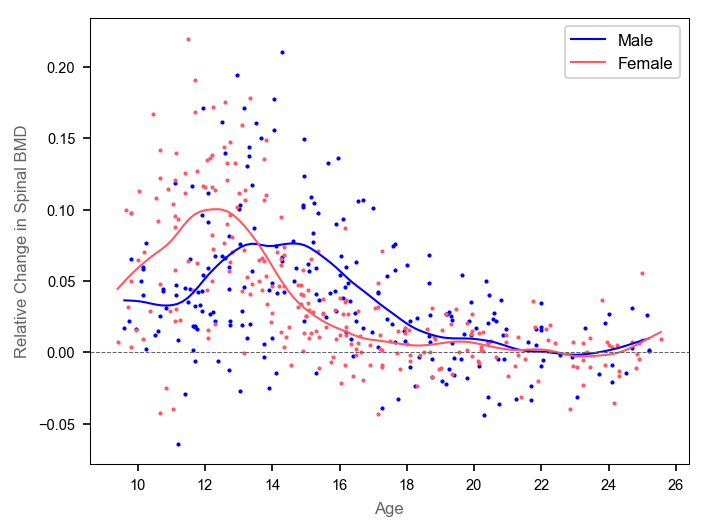

In [10]:
# PAGE 152. FIGURE 5.6. The response is the relative change in bone mineral
#           density measured at the spine in adolescents, as a function of age.
#           A separate smoothing spline was fit to the males and females, with
#           λ ≈ 0.00022. This choice corresponds to about 12 degrees of
#           freedom. The data are color coded by gender, and two separate
#           curves were fit. This simple summary reinforces the evidence in the
#           data that the growth spurt for females precedes that for males by
#           about two years.
fig, ax = plt.subplots(figsize=(5.15, 3.94), dpi=150)
ax.plot(x_plot_male, y_plot_male, color=BLUE, linewidth=1, label='Male')
ax.plot(x_plot_female, y_plot_female, color=RED, linewidth=1, label='Female')
ax.scatter(df_male.age.values, df_male.spnbmd.values, color=BLUE, s=1)
ax.scatter(df_female.age.values, df_female.spnbmd.values, color=RED, s=1)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.axhline(y=0, c=GRAY4, linewidth=0.5, linestyle='--')
ax.set_xlabel('Age', color=GRAY4, fontsize=8)
ax.set_ylabel('Relative Change in Spinal BMD', color=GRAY4, fontsize=8)
_ = ax.legend(loc='upper right', prop={'size': 8})